In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.filters
import scipy.io as sio
import similaritymeasures

In [2]:

def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
    return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return cov


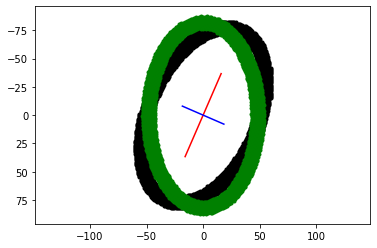

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.filters


img = imageio.imread('../../Desktop/rangamani/oval.png')
y, x = np.nonzero(img)

x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])

cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

scale = 20
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
theta = np.tanh((x_v1)/(y_v1))  
#print(theta)
rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
# plot the transformed blob
x_transformed, y_transformed = transformed_mat.A
plt.plot(x_transformed, y_transformed, 'g.')




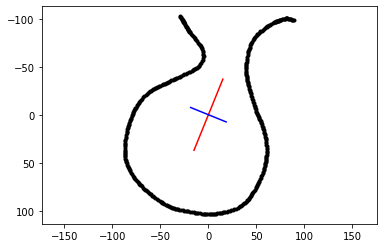

In [4]:
mat_contents = sio.loadmat('../emm/matfiles/184.mat')
#plt.plot(mat_contents['fit'][:, 0],mat_contents['fit'][:, 1])


y = mat_contents['fit'][:, 1]
x = mat_contents['fit'][:, 0]

x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])

cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

scale = 20
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
theta = np.tanh((x_v1)/(y_v1))  
#print(theta)
rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
# plot the transformed blob
x_transformed, y_transformed = transformed_mat.A
#plt.plot(x_transformed, y_transformed, 'g.')


In [62]:
def read_mat_file(path):
    mat_contents = sio.loadmat(path)
    return {'x_fit': mat_contents['fit'][:,0], 'y_fit': mat_contents['fit'][:, 1], 'x_outerfit': mat_contents['outerfit'][:, 0], 'y_outerfit': mat_contents['outerfit'][:, 1]}

def smooth(x, box_pts): #for correcting ragged edges; not in use right now
    box = np.ones(box_pts)/box_pts
    x_smooth = np.convolve(x, box, mode='same')
    return x_smooth

def make_graph(data):
    if (isinstance(data, dict)):
        plt.plot(data['x_fit'], data['y_fit'])
        plt.plot(data['x_outerfit'], data['y_outerfit'])
    elif (isinstance(data, tuple)):
        plt.plot(data[0], data[1])
        
def make_symmetric(data, fit_or_outerfit = "fit"):
    if (fit_or_outerfit == "fit"):
        x_fit_data = data['x_fit']
        y_fit_data = data['y_fit']
    else:
        x_fit_data = data['x_outerfit']
        y_fit_data = data['y_outerfit']
        
    new_x_fit_data = np.absolute(x_fit_data) #that way we can calculate average x coord

    x_fit_data_transformed = np.zeros(len(new_x_fit_data)) #initialize resulting arrays
    y_fit_data_transformed = np.zeros(len(y_fit_data))
    
    x_start = np.argmin(np.absolute(0 - new_x_fit_data)) #what index has the value closest to 0 (so we know if the shape is skewed left/right)
    dist_from_mid = abs(len(new_x_fit_data) // 2 - x_start) #how far x_start is away from the actual middle of the array (used to shift resulting graph)

    #since x_start will rarely be exactly at middle of array, below expression ensures against arrayindexoutofbounds.
    for i in range(x_start if x_start <= (len(x_fit_data_transformed) // 2) else len(x_fit_data_transformed) - x_start):
        #since we want resulting figure to be perfectly symmetrical, we start from the middle of the new array and every value to left and right are the same
        x_fit_data_transformed[len(x_fit_data_transformed) // 2 - i] = - (new_x_fit_data[x_start - i] + new_x_fit_data[x_start + i]) / 2
        x_fit_data_transformed[len(x_fit_data_transformed) // 2 + i] = (new_x_fit_data[x_start - i] + new_x_fit_data[x_start + i]) / 2

    for i in range(len(y_fit_data_transformed) // 2 + 1):
        y_fit_data_transformed[i] = (y_fit_data[i] + y_fit_data[-1 - i]) / 2
        y_fit_data_transformed[-1 - i] = (y_fit_data[i] + y_fit_data[-1 - i]) / 2        
    
    #after the above loops, there are some values we didn't take into account in the calculations, so we do them here
    leftover_data = (new_x_fit_data[0:dist_from_mid + 1] + new_x_fit_data[len(new_x_fit_data) - dist_from_mid - 1:]) / 2
    
    x_fit_data_transformed[0:dist_from_mid + 1] = - np.flip(leftover_data) #the first few data
    x_fit_data_transformed[len(new_x_fit_data) - dist_from_mid - 1:] = leftover_data #the last few datapoints
    #NOTE: the resulting array is not PERFECTLY symmetrical; sometimes it can be off by one x value
    return x_fit_data_transformed, y_fit_data_transformed

def pca(x, y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    scale = 20
    #plt.plot([x_v1*-scale*2, x_v1*scale*2], [y_v1*-scale*2, y_v1*scale*2], color='red')
    #plt.plot([x_v2*-scale, x_v2*scale], [y_v2*-scale, y_v2*scale], color='blue')
    #plt.plot(x, y, 'k.')
    #plt.axis('equal')
    #plt.gca().invert_yaxis()  # Match the image system with origin at top left
    theta = np.tanh((x_v1)/(y_v1))  
    #print(theta)
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                          [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
    # plot the transformed blob
    x_transformed, y_transformed = transformed_mat.A
    return x_transformed, y_transformed

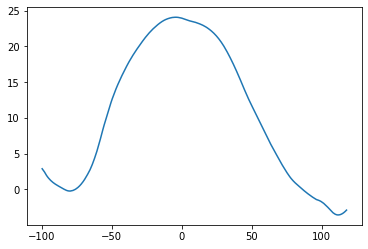

In [69]:
data = read_mat_file('../emm/matfiles/3.mat')
make_graph((data['x_fit'], data['y_fit']))
new_x, new_y = pca(data['x_fit'], data['y_fit'])

#results = make_symmetric({'x_fit': new_x, 'y_fit': new_y})

#make_graph((x_transformed, y_transformed))
#results = make_symmetric({'x_fit': x_transformed, 'y_fit': y_transformed})

#make_graph(results)

In [40]:
df = similaritymeasures.frechet_dist(results, (data['x_fit'], data['y_fit']))
print(df)

100.72138685526576
